# **Implementación del modelo HGT al dataset *Bitcoin Elliptic++***
---

Autor: Víctor Pérez Cano (victor.perezcano@estudiante.uam.es)

---
HGT *(Heterogeneus Graph Transformer)* es un modelo de aprendizaje automático para la construcción de representaciones para nodos de un grafo heterogéneo. Utiliza mecanismos de atención *multi-head* y varias capas de paso de mensajes al estilo de una GNN *(Graph Neural Network)*.
>> Hu, Z., Dong, Y., Wang, K., & Sun, Y. (2020, April). Heterogeneous graph transformer. In *Proceedings of the web conference 2020* (pp. 2704-2710). [https://arxiv.org/abs/2003.01332](https://https://arxiv.org/abs/2003.01332)

---

*Elliptic++* es un dataset de transacciones y actores (wallets) de Bitcoin creado en 2023 a partir del dataset *Elliptic* original. Cuenta con 203 mil transacciones y 822 mil wallets, además de las interacciones entre ambas. En ambos conjuntos los nodos están etiquetados como 1 (ilícito), 2 (lícito) o 3 (desconocido).
>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics. [https://dl.acm.org/doi/pdf/10.1145/3580305.3599803](https://dl.acm.org/doi/pdf/10.1145/3580305.3599803)

---
---

# **1. Preparación**

In [ ]:
#@title ### Instalación de librerías

!pip install matplotlib
!pip install scikit-learn
!pip install networkx

import torch

!pip install torch_geometric

# Optional dependencies:
if torch.cuda.is_available():
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
else:
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 106.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 75.2 MB/s eta 0:00:00


# **2. Obtención de los datos**

## 2.1 Obtener CSVs

### Opción A: Descargar dataset de Internet

In [ ]:
!mkdir -p Datasets
!gdown https://drive.google.com/drive/folders/1MRPXz79Lu_JGLlJ21MDfML44dKN9R08l?usp=sharing --folder -O Datasets/

Retrieving folder contents
Processing file 1x5JdNWX8fVM3FO8I0wOLDAeh2qaB53uV AddrAddr_edgelist.csv
Processing file 16eWZTe-dsjEqgsOqFtg78m4fYhcxKlmZ AddrTx_edgelist.csv
Processing file 1SYpun0DMDt-h3sbI60G55jNsfwnFTHXg TxAddr_edgelist.csv
Processing file 1DiBxn8TXdbJqoSw58pYUeaqO3oOKhuQO txs_classes.csv
Processing file 1Q2yG_CIDvfdGP-fKVPSw979EYgQukjz5 txs_edgelist.csv
Processing file 19q09IFhfkOOBOXvn_dKhWjILJtjCcsjc txs_features.csv
Processing file 1ZaACVE4wSIx7r8Z9ze7ExQnJ0wzGrVkp wallets_classes.csv
Processing file 1YLCIn8rPAh4FjKiZynblU2rLx-Fxr2WA wallets_features_classes_combined.csv
Processing file 1mhrrobYdnaxYBIVK06EpKB2EwV-ERlce wallets_features.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1x5JdNWX8fVM3FO8I0wOLDAeh2qaB53uV
From (redirected): https://drive.google.com/uc?id=1x5JdNWX8fVM3FO8I0wOLDAeh2qaB53uV&confirm=t&uuid=873a1323-9ee1-4685-9602-726f3c9

### Opción B: Obtener dataset de la Unidad de Drive

In [ ]:
from google.colab import drive
from os import path as osp

drive.mount('/content/gdrive',force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks/TFG Infor'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/TFG Infor



## 2.2. Creación de dataframes de Pandas a partir de los CSVs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

class_mapping = {
    1: 1,
    2: 0,
    3: 2
}

# Wallets
# Load CSVs
df_wallet_features = pd.read_csv("./Datasets/Elliptic++ Dataset/wallets_features.csv")
df_wallet_classes = pd.read_csv("./Datasets/Elliptic++ Dataset/wallets_classes.csv")
# Normalize features
wallet_feature_columns = df_wallet_features.columns[2:]
wallet_normalized_features = normalize(df_wallet_features[wallet_feature_columns].values, axis=0)
df_wallet_normalized = pd.DataFrame(wallet_normalized_features, columns=wallet_feature_columns)
df_wallet_normalized['address'] = df_wallet_features['address']
df_wallet_normalized['Time step'] = df_wallet_features['Time step']
# Map class labels
df_wallet_classes['class'] = df_wallet_classes['class'].map(class_mapping)
# Join class and features
df_wallet = pd.merge(df_wallet_classes, df_wallet_normalized, on='address', how='inner')

# Transacciones
# Load CSVs
df_tnx_features = pd.read_csv("./Datasets/Elliptic++ Dataset/txs_features.csv")
df_tnx_classes = pd.read_csv("./Datasets/Elliptic++ Dataset/txs_classes.csv")
# Drop NaNs
df_tnx_nan = df_tnx_features[df_tnx_features.isna().any(axis=1)]['txId'].tolist()
df_tnx_features = df_tnx_features.dropna()
df_tnx_classes = df_tnx_classes[~df_tnx_classes['txId'].isin(df_tnx_nan)]
# Normalize features
tnx_feature_columns = df_tnx_features.columns[2:]
tnx_normalized_features = normalize(df_tnx_features[tnx_feature_columns].values, axis=0)
df_tnx_normalized = pd.DataFrame(tnx_normalized_features, columns=tnx_feature_columns)
df_tnx_normalized['txId'] = df_tnx_features['txId']
df_tnx_normalized['Time step'] = df_tnx_features['Time step']
# Map class labels
df_tnx_classes['class'] = df_tnx_classes['class'].map(class_mapping)
# Join class and features
df_tnx = pd.merge(df_tnx_classes, df_tnx_normalized, on='txId', how='inner')

# Edgelist
df_AddrTx_edgelist = pd.read_csv("./Datasets/Elliptic++ Dataset/AddrTx_edgelist.csv")
df_AddrTx_edgelist = df_AddrTx_edgelist[~df_AddrTx_edgelist['txId'].isin(df_tnx_nan)]
df_TxAddr_edgelist = pd.read_csv("./Datasets/Elliptic++ Dataset/TxAddr_edgelist.csv")
df_TxAddr_edgelist = df_TxAddr_edgelist[~df_TxAddr_edgelist['txId'].isin(df_tnx_nan)]

In [ ]:
df_wallet

,address,class,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median,Time step
0,111112TykSw72ztDN2WJger4cynzWYC5w,0,0.00000,0.000019,0.000895,0.000884,0.000000e+00,0.000008,0.000000,0.000982,...,0.000000,0.00000,0.00000,0.0,0.000047,0.000804,0.000085,0.000751,0.000786,25
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,2,0.00000,0.000153,0.000895,0.000977,2.305585e-03,0.000060,0.000000,0.000982,...,0.002019,0.00096,0.00118,0.0,0.000016,0.000804,0.000085,0.000751,0.000786,25
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,2,0.00000,0.000153,0.000895,0.000977,2.305585e-03,0.000060,0.000000,0.000982,...,0.002019,0.00096,0.00118,0.0,0.000016,0.000804,0.000085,0.000751,0.000786,29
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,2,0.00000,0.000153,0.000895,0.000977,2.305585e-03,0.000060,0.000000,0.000982,...,0.002019,0.00096,0.00118,0.0,0.000016,0.000804,0.000085,0.000751,0.000786,39
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,2,0.00000,0.000153,0.000895,0.000977,2.305585e-03,0.000060,0.000000,0.000982,...,0.002019,0.00096,0.00118,0.0,0.000016,0.000804,0.000085,0.000751,0.000786,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268255,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,2,0.00001,0.000019,0.000920,0.000908,4.972147e-08,0.000015,0.001194,0.001009,...,0.000000,0.00000,0.00000,0.0,0.000006,0.000804,0.000085,0.000751,0.000786,31
1268256,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,2,0.00000,0.000019,0.000973,0.000960,0.000000e+00,0.000008,0.000000,0.001068,...,0.000000,0.00000,0.00000,0.0,0.000002,0.000804,0.000085,0.000751,0.000786,44
1268257,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,2,0.00000,0.000019,0.000829,0.000819,0.000000e+00,0.000008,0.000000,0.000910,...,0.000000,0.00000,0.00000,0.0,0.000002,0.000804,0.000085,0.000751,0.000786,9
1268258,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,2,0.00000,0.000019,0.000805,0.000794,0.000000e+00,0.000008,0.000000,0.000883,...,0.000000,0.00000,0.00000,0.0,0.000002,0.000804,0.000085,0.000751,0.000786,3


In [ ]:
df_tnx

,txId,class,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,Time step
0,3321,2,-0.000376,-0.000409,-0.002666,-0.000270,-0.000097,-0.00025,-0.000136,-0.000355,...,0.000007,0.000008,0.000008,0.000007,3.366302e-05,0.000005,0.000009,8.864797e-06,0.000007,1
1,11108,2,-0.000305,-0.000409,-0.002666,-0.000270,-0.000097,-0.00025,-0.000136,-0.000282,...,0.000078,0.000079,0.000079,0.000077,1.182336e-04,0.000071,0.000091,9.316449e-05,0.000077,1
2,51816,2,-0.000377,-0.000409,-0.002666,-0.000270,-0.000097,-0.00025,-0.000136,-0.000356,...,0.000006,0.000006,0.000006,0.000006,4.598494e-05,0.000003,0.000007,7.578770e-06,0.000006,1
3,68869,0,-0.000253,-0.000409,-0.002666,0.000062,-0.000097,-0.00025,0.001212,-0.000358,...,0.000111,0.000044,0.000014,0.000128,2.478856e-04,0.000114,0.000152,1.545410e-04,0.000128,1
4,89273,0,0.011525,-0.000467,-0.003898,-0.000270,0.576182,-0.00025,-0.000136,0.011821,...,0.011844,0.012005,0.012007,0.011733,2.622061e-11,0.000584,0.000002,1.463099e-08,0.011733,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202799,194747812,2,0.001237,-0.000441,-0.000203,-0.000270,-0.000097,-0.00025,-0.000136,0.001295,...,0.001612,0.001634,0.001634,0.001597,3.334656e-04,0.001618,0.001889,1.925003e-03,0.001597,49
202800,194747925,2,0.001213,-0.000441,-0.000203,-0.000270,-0.000097,-0.00025,-0.000136,0.001271,...,0.001588,0.001610,0.001610,0.001573,4.105139e-06,0.001617,0.001861,1.896734e-03,0.001573,49
202801,194748063,2,0.001204,-0.000441,-0.000203,-0.000270,-0.000097,-0.00025,-0.000136,0.001262,...,0.001579,0.001600,0.001601,0.001564,1.867208e-04,0.001596,0.001851,1.886053e-03,0.001564,49
202802,194748070,2,0.001191,-0.000441,-0.000203,-0.000270,-0.000097,-0.00025,-0.000136,0.001249,...,0.001566,0.001587,0.001588,0.001551,6.105307e-05,0.001591,0.001836,1.870684e-03,0.001551,49


---
# Primera aproximación
---

En esta primera aproximación utilizo los $T$ primeros *timesteps* del *dataset* para el entrenamiento del modelo y el resto para su evaluación. El principal inconveniente que he encontrado es que en cada *timestep* el tamaño del lote era distinto, y el desbalanceo entre las clases ilícitas y las lícitas de cada tipo de nodo era distinto.

Para hacer frente a esto último he utilizado como función de pérdida ```BCEWithLogitLoss``` que me permite especificar en su parámetro ```pos_weight``` el desbalanceo de la clase positiva. He utilizado un parámetro distinto para cada lote del entrenamiento en función del desbalanceo de cada tipo de nodo en ese lote.

## **2.3. Creación del dataset de PyG**


#### Creación de un objeto ```HeteroData``` para cada *time step*

> El objetivo es poder cargarlos después en un ```DataLoader``` básico para poder aplicar entrenamiento por *Mini batching*.

In [ ]:
def get_masked_edges(masked_df_wallet, masked_df_tx):
    addr_mapping = {addr: idx for idx, addr in enumerate(masked_df_wallet['address'].values)}
    tnx_mapping = {tnx: idx for idx, tnx in enumerate(masked_df_tx['txId'].values)}

    AddrTx_mask = df_AddrTx_edgelist['input_address'].isin(masked_df_wallet['address'].values) & df_AddrTx_edgelist['txId'].isin(masked_df_tx['txId'].values)
    masked_df_AddrTx_edgelist = df_AddrTx_edgelist[AddrTx_mask]
    masked_df_AddrTx_byIdx = pd.DataFrame()
    masked_df_AddrTx_byIdx['source'] = masked_df_AddrTx_edgelist['input_address'].map(addr_mapping)
    masked_df_AddrTx_byIdx['dest'] = masked_df_AddrTx_edgelist['txId'].map(tnx_mapping)

    TxAddr_mask = df_TxAddr_edgelist['txId'].isin(masked_df_tx['txId'].values) & df_TxAddr_edgelist['output_address'].isin(masked_df_wallet['address'].values)
    masked_df_TxAddr_edgelist = df_TxAddr_edgelist[TxAddr_mask]
    masked_df_TxAddr_byIdx = pd.DataFrame()
    masked_df_TxAddr_byIdx['source'] = masked_df_TxAddr_edgelist['txId'].map(tnx_mapping)
    masked_df_TxAddr_byIdx['dest'] = masked_df_TxAddr_edgelist['output_address'].map(addr_mapping)

    return masked_df_AddrTx_byIdx, masked_df_TxAddr_byIdx

In [ ]:
import numpy as np
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm

dataset = dict()

for t in tqdm(range(1, 50)):
    dataset[t] = HeteroData()

    masked_df_wallet = df_wallet[df_wallet['Time step'] == t]
    masked_df_tnx = df_tnx[df_tnx['Time step'] == t]

    # Wallets
    dataset[t]['wallet'].x = torch.tensor(masked_df_wallet[wallet_feature_columns].values).float()
    dataset[t]['wallet'].y = torch.tensor(masked_df_wallet.iloc[:,1].values).float()
    # Balance number of licit/illicit wallets
    licit_wallets = masked_df_wallet[masked_df_wallet['class'] == 0]
    illicit_wallets = masked_df_wallet[masked_df_wallet['class'] == 1]
    dataset[t]['wallet'].train_mask = torch.tensor(masked_df_wallet.index.isin(licit_wallets.index) | masked_df_wallet.index.isin(illicit_wallets.index))
    dataset[t]['wallet'].test_mask = torch.tensor(masked_df_wallet.index.isin(licit_wallets.index) | masked_df_wallet.index.isin(illicit_wallets.index))

    # Transacciones
    dataset[t]['tnx'].x = torch.tensor(masked_df_tnx[tnx_feature_columns].values).float()
    dataset[t]['tnx'].y = torch.tensor(masked_df_tnx.iloc[:,1].values).float()
    # Balance number of licit/illicit transactions
    licit_tnx = masked_df_tnx[masked_df_tnx['class'] == 0]
    illicit_tnx = masked_df_tnx[masked_df_tnx['class'] == 1]
    dataset[t]['tnx'].train_mask = torch.tensor(masked_df_tnx.index.isin(licit_tnx.index) | masked_df_tnx.index.isin(illicit_tnx.index))
    dataset[t]['tnx'].test_mask = torch.tensor(masked_df_tnx.index.isin(licit_tnx.index) | masked_df_tnx.index.isin(illicit_tnx.index))

    # Conexiones Wallet -> Transaccion y Transaccion -> Wallet
    masked_df_AddrTx_byIdx, masked_df_TxAddr_byIdx = get_masked_edges(masked_df_wallet, masked_df_tnx)
    dataset[t]['wallet', 'sends', 'tnx'].edge_index = torch.from_numpy(masked_df_AddrTx_byIdx.values).t().contiguous()
    dataset[t]['tnx', 'delivers', 'wallet'].edge_index = torch.from_numpy(masked_df_TxAddr_byIdx.values).t().contiguous()
    try:
        dataset[t].validate()
    except ValueError as err:
        print(f'Fallo en el timestep {t}')
        print(err)
        raise

metadata = dataset[1].metadata()    # Es el mismo para todos los time steps

#### Otras posibilidades:
*   Codificar el tiempo con RTE como se hace en el artículo de HGT
*   Utilizar HGTSampling mediante ```HGTLoader```
*   Crear un objeto ```Dataset``` de PyG con todas las características



TODO...

## **3. Construcción del modelo**

In [ ]:
from torch.nn import Sigmoid, LeakyReLU, ModuleDict
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear

class HGT_BinaryClassifier(torch.nn.Module):
    """
    Utiliza el modelo HGT para realizar una clasificación binaria sobre
    todos los nodos de todos los tipos en el grafo, además de guardar
    embeddings para cada nodo.
    """
    def __init__(self, embedding_dim, metadata, num_heads, num_layers):
        super().__init__()
        self.metadata = metadata

        # Se podría usar HeteroDictLinear pero no permite funciones de activación
        self.in_lin_dict = ModuleDict()
        self.out_lin_dict = ModuleDict()
        self.l = LeakyReLU()
        for node_type in self.metadata[0]:   # Node types
            self.in_lin_dict[node_type] = Linear(-1, embedding_dim)
            self.out_lin_dict[node_type] = Linear(embedding_dim, 1)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(embedding_dim, embedding_dim, self.metadata,
                           num_heads)
            self.convs.append(conv)


    def forward(self, x_dict, edge_index_dict):
        """
        Primero se aplica una transformación lineal seguida de la función de
        activación LeakyReLU para cada tipo de nodo, con el objetivo de que
        todos los tipos trabajen en las mismas dimensiones.
        """
        x_dict = {
            node_type: self.l(self.in_lin_dict[node_type](x))
            for node_type, x in x_dict.items()
        }

        """
        Se aplican todas las capas convolucionales del modelo HGT
        """
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {
                node_type: self.l(x_dict[node_type])
                for node_type in x_dict.keys()
            }


        """
        Se aplica una última transformación lineal para obtener un único
        valor (Logit) de salida.
        """
        x_dict = {
            node_type: self.out_lin_dict[node_type](x).t()[0]
            for node_type, x in x_dict.items()
        }

        return x_dict

    def reset_parameters(self):
        for node_type in self.metadata[0]:
            self.in_lin_dict[node_type].reset_parameters()
            self.out_lin_dict[node_type].reset_parameters()

        for conv in self.convs:
            conv.reset_parameters()


## **4. Entrenamiento del modelo**

Entrenamiento con ```DataLoader``` y  *mini batching*

In [ ]:
from torch_geometric.loader import DataLoader
from torch.nn import BCEWithLogitsLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(train_loader, balance=0.5, wallet_imbalances=None, tnx_imbalances=None):
    global model
    global optimizer

    if wallet_imbalances is None or len(wallet_imbalances) != len(train_loader):
        print('Wallet imbalances no válido')
        wallet_imbalances = [1]*len(train_loader)
    if tnx_imbalances is None or len(tnx_imbalances) != len(train_loader):
        print('Transaction imbalances no válido')
        tnx_imbalances = [1]*len(train_loader)

    model.train()

    total_wallet_loss = total_tnx_loss = 0
    total_wallet_samples = total_tnx_samples = 0

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        batch = batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)

        wallet_mask = batch['wallet'].train_mask
        wallet_num = wallet_mask.sum()
        tnx_mask = batch['tnx'].train_mask
        tnx_num = tnx_mask.sum()

        wallet_loss_func = BCEWithLogitsLoss(pos_weight=wallet_imbalances[i])
        tnx_loss_func = BCEWithLogitsLoss(pos_weight=tnx_imbalances[i])

        wallet_loss = wallet_loss_func(out['wallet'][wallet_mask], batch['wallet'].y[wallet_mask])
        tnx_loss = tnx_loss_func(out['tnx'][tnx_mask], batch['tnx'].y[tnx_mask])

        loss = wallet_loss*balance + tnx_loss*(1-balance)
        loss.backward()
        optimizer.step()

        total_wallet_loss += float(wallet_loss) * wallet_num
        total_wallet_samples += wallet_num
        total_tnx_loss += float(tnx_loss) * tnx_num
        total_tnx_samples += tnx_num

    return (total_wallet_loss/total_wallet_samples), (total_tnx_loss/total_tnx_samples)


@torch.no_grad()
def test(test_loader, threshold=0.5):
    global model

    model.eval()

    wallet_total_pred = wallet_correct_pred = 0
    tnx_total_pred = tnx_correct_pred = 0

    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch.x_dict, batch.edge_index_dict)

        wallet_test_mask = batch['wallet'].test_mask
        wallet_bin_pred = (torch.sigmoid(pred['wallet']) > threshold).float()
        wallet_correct_pred += (wallet_bin_pred[wallet_test_mask] == batch['wallet'].y[wallet_test_mask]).sum()
        wallet_total_pred += wallet_test_mask.sum()

        tnx_test_mask = batch['tnx'].test_mask
        tnx_bin_pred = (torch.sigmoid(pred['tnx']) > threshold).float()
        tnx_correct_pred += (tnx_bin_pred[tnx_test_mask] == batch['tnx'].y[tnx_test_mask]).sum()
        tnx_total_pred += tnx_test_mask.sum()

    wallet_acc = wallet_correct_pred / wallet_total_pred
    tnx_acc = tnx_correct_pred / tnx_total_pred
    return wallet_acc, tnx_acc


In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def train_and_eval(balance, timestep, batch_size, num_epochs, lr, wd, th=0.5, verbose=False):
    global model
    global optimizer

    train_loader = DataLoader([dataset[t] for t in range(1,timestep)], batch_size=batch_size)
    test_loader = DataLoader([dataset[t] for t in range(timestep,50)], batch_size=batch_size)

    if verbose:
        print(f'--------------------------------------------------------------------')
        print(f'Using {len(train_loader)} training batches')
        print(f'Using {len(test_loader)} testing batches')
        print(f'--------------------------------------------------------------------')

    wallet_imbalances = []
    tnx_imbalances = []
    for i, batch in enumerate(train_loader):
        wallet_mask = batch['wallet'].train_mask
        wallet_true_labels = batch['wallet'].y[wallet_mask]
        wallet_imbalances.append((wallet_true_labels==0).sum() / wallet_true_labels.sum())
        tnx_mask = batch['tnx'].train_mask
        tnx_true_labels = batch['tnx'].y[tnx_mask]
        tnx_imbalances.append((tnx_true_labels==0).sum() / tnx_true_labels.sum())
        if verbose:
            print(f'Batch {i} wallet imbalance: {wallet_imbalances[i]:.2f}, transactions imbalance: {tnx_imbalances[i]:.2f}')
    if verbose:
        print(f'--------------------------------------------------------------------')

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    epochs = range(1,num_epochs+1)
    wallet_loss_list = []
    tnx_loss_list = []

    for epoch in tqdm(epochs):
        wallet_loss, tnx_loss = train(train_loader, balance, wallet_imbalances, tnx_imbalances)
        train_wallet_acc, train_tnx_acc = test(train_loader, threshold=th)
        test_wallet_acc, test_tnx_acc = test(test_loader, threshold=th)
        if verbose and epoch%10 == 0:
            print(f'-------------------------- Epoch: {epoch:03d}/{num_epochs:03d} --------------------------')
            print(f'Wallets loss: {wallet_loss:.8f},\tTransactions loss: {tnx_loss:.8f}')
            print(f'Train set wallets ACC: {train_wallet_acc:.4f},\tTrain set transactions ACC: {train_tnx_acc:.4f}')
            print(f'Test set wallets ACC: {test_wallet_acc:.4f},\tTest set transactions ACC: {test_tnx_acc:.4f}')
            print(f'--------------------------------------------------------------------')
        wallet_loss_list.append(wallet_loss.cpu())
        tnx_loss_list.append(tnx_loss.cpu())

    plt.plot(epochs, wallet_loss_list, label='Wallets loss', color='orange')
    plt.plot(epochs, tnx_loss_list, label='Transactions loss', color='cyan')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Wallet and transaction loss evolution')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_curve

def evaluation_report():
    test_loader = DataLoader([dataset[t] for t in range(33,50)], batch_size=8)

    all_wallet_probs = []
    all_wallet_labels = []
    all_tnx_probs = []
    all_tnx_labels = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch.x_dict, batch.edge_index_dict)

            wallet_test_mask = batch['wallet'].test_mask
            all_wallet_probs.extend(torch.sigmoid(pred['wallet'][wallet_test_mask]).cpu().numpy())
            all_wallet_labels.extend(batch['wallet'].y[wallet_test_mask].cpu().numpy())

            tnx_test_mask = batch['tnx'].test_mask
            all_tnx_probs.extend(torch.sigmoid(pred['tnx'][tnx_test_mask]).cpu().numpy())
            all_tnx_labels.extend(batch['tnx'].y[tnx_test_mask].cpu().numpy())

    all_wallet_probs = np.array(all_wallet_probs)
    all_wallet_labels = np.array(all_wallet_labels)
    all_tnx_probs = np.array(all_tnx_probs)
    all_tnx_labels = np.array(all_tnx_labels)

    all_wallet_preds = np.round(all_wallet_probs)
    all_tnx_preds = np.round(all_tnx_probs)

    if (len(np.unique(all_wallet_preds)) > 1):
        print('Wallets classification report:')
        print(classification_report(all_wallet_labels, all_wallet_preds, target_names=['Licit', 'Illicit']))
        print(f'Wallets accuracy score: {accuracy_score(all_wallet_labels, all_wallet_preds)}')
        print('')
    if (len(np.unique(all_tnx_preds)) > 1):
        print('Transactions classification report:')
        print(classification_report(all_tnx_labels, all_tnx_preds, target_names=['Licit', 'Illicit']))
        print(f'Transactions accuracy score: {accuracy_score(all_tnx_labels, all_tnx_preds)}')
        print('')

    sns.heatmap(confusion_matrix(all_wallet_labels, all_wallet_preds), annot=True, fmt='d',
                xticklabels=['Lícito', 'Ilícito'],
                yticklabels=['Lícito', 'Ilícito'])
    plt.title(f'Matriz de confusión para wallets')
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas reales')
    plt.show()

    sns.heatmap(confusion_matrix(all_tnx_labels, all_tnx_preds), annot=True, fmt='d',
                xticklabels=['Lícito', 'Ilícito'],
                yticklabels=['Lícito', 'Ilícito'])
    plt.title(f'Matriz de confusión para transacciones')
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas reales')
    plt.show()


## **5. Experimentos**

### 5.1. Optimizando solo transacciones

--------------------------------------------------------------------
Using 5 training batches
Using 2 testing batches
--------------------------------------------------------------------
Batch 0 wallet imbalance: 68.84, transactions imbalance: 40.31
Batch 1 wallet imbalance: 11.12, transactions imbalance: 4.18
Batch 2 wallet imbalance: 8.24, transactions imbalance: 7.00
Batch 3 wallet imbalance: 4.08, transactions imbalance: 3.46
Batch 4 wallet imbalance: 8.41, transactions imbalance: 13.12
--------------------------------------------------------------------


  0%|          | 0/400 [00:00<?, ?it/s]

-------------------------- Epoch: 010/400 --------------------------
Wallets loss: 1.27079952,	Transactions loss: 1.23004687
Train set wallets ACC: 0.9167,	Train set transactions ACC: 0.2169
Test set wallets ACC: 0.9364,	Test set transactions ACC: 0.1052
--------------------------------------------------------------------
-------------------------- Epoch: 020/400 --------------------------
Wallets loss: 1.27079904,	Transactions loss: 1.23004484
Train set wallets ACC: 0.9167,	Train set transactions ACC: 0.8873
Test set wallets ACC: 0.9364,	Test set transactions ACC: 0.9353
--------------------------------------------------------------------
-------------------------- Epoch: 030/400 --------------------------
Wallets loss: 1.27079880,	Transactions loss: 1.23003638
Train set wallets ACC: 0.9167,	Train set transactions ACC: 0.4214
Test set wallets ACC: 0.9364,	Test set transactions ACC: 0.2937
--------------------------------------------------------------------
-------------------------- E

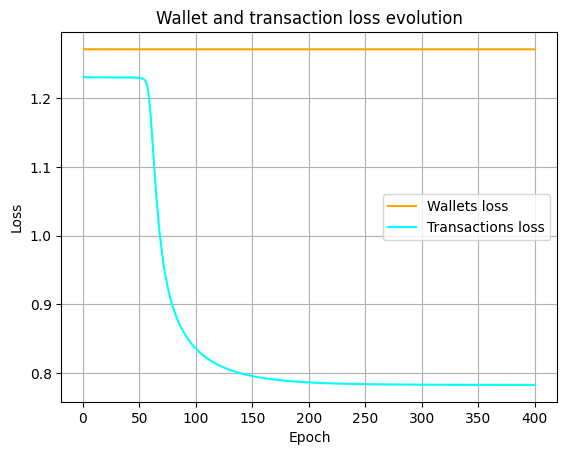

In [ ]:
model = HGT_BinaryClassifier(embedding_dim=64, metadata=metadata, num_heads=8, num_layers=2).to(device)
train_and_eval(balance=0, timestep=37, batch_size=8, num_epochs=400, lr=0.01, wd=0.001, th=0.5, verbose=True)

Transactions classification report:
              precision    recall  f1-score   support

       Licit       0.99      0.69      0.81     16158
     Illicit       0.17      0.88      0.28      1143

    accuracy                           0.70     17301
   macro avg       0.58      0.78      0.55     17301
weighted avg       0.93      0.70      0.78     17301

Transactions accuracy score: 0.7020981446159181



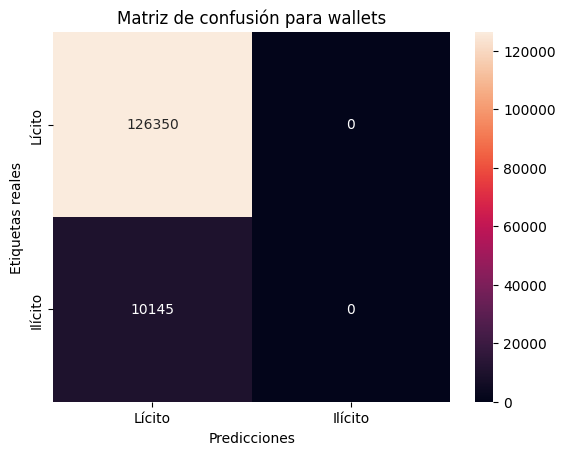

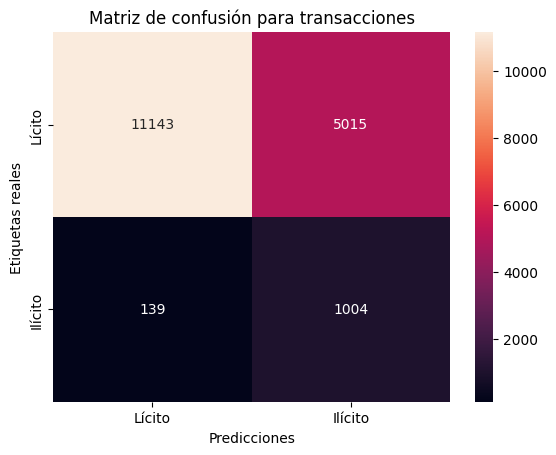

In [ ]:
evaluation_report()

### 5.2. Optimizando solo wallets

--------------------------------------------------------------------
Using 5 training batches
Using 2 testing batches
--------------------------------------------------------------------
Batch 0 wallet imbalance: 68.84, transactions imbalance: 40.31
Batch 1 wallet imbalance: 11.12, transactions imbalance: 4.18
Batch 2 wallet imbalance: 8.24, transactions imbalance: 7.00
Batch 3 wallet imbalance: 4.08, transactions imbalance: 3.46
Batch 4 wallet imbalance: 8.41, transactions imbalance: 13.12
--------------------------------------------------------------------


  0%|          | 0/400 [00:00<?, ?it/s]

-------------------------- Epoch: 010/400 --------------------------
Wallets loss: 1.15640855,	Transactions loss: 1.23007500
Train set wallets ACC: 0.5834,	Train set transactions ACC: 0.1127
Test set wallets ACC: 0.4941,	Test set transactions ACC: 0.0647
--------------------------------------------------------------------
-------------------------- Epoch: 020/400 --------------------------
Wallets loss: 0.97243398,	Transactions loss: 1.23006117
Train set wallets ACC: 0.5204,	Train set transactions ACC: 0.8873
Test set wallets ACC: 0.3880,	Test set transactions ACC: 0.9353
--------------------------------------------------------------------
-------------------------- Epoch: 030/400 --------------------------
Wallets loss: 0.95914161,	Transactions loss: 1.23006165
Train set wallets ACC: 0.5842,	Train set transactions ACC: 0.1127
Test set wallets ACC: 0.4716,	Test set transactions ACC: 0.0647
--------------------------------------------------------------------
-------------------------- E

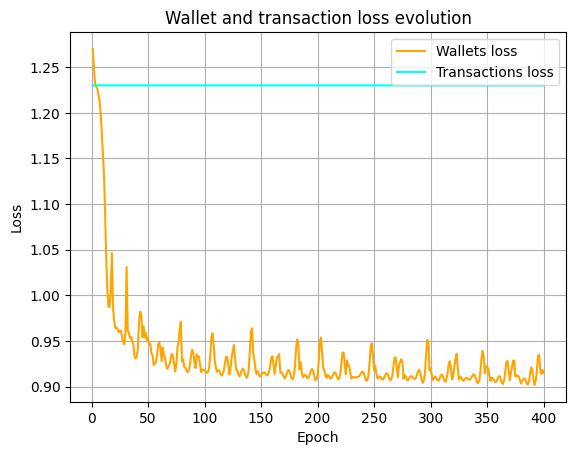

In [ ]:
model = HGT_BinaryClassifier(embedding_dim=64, metadata=metadata, num_heads=8, num_layers=2).to(device)
train_and_eval(balance=1, timestep=37, batch_size=8, num_epochs=400, lr=0.01, wd=0.001, th=0.5, verbose=True)

Wallets classification report:
              precision    recall  f1-score   support

       Licit       0.99      0.36      0.52    126350
     Illicit       0.11      0.97      0.19     10145

    accuracy                           0.40    136495
   macro avg       0.55      0.66      0.36    136495
weighted avg       0.93      0.40      0.50    136495

Wallets accuracy score: 0.4020733360196344



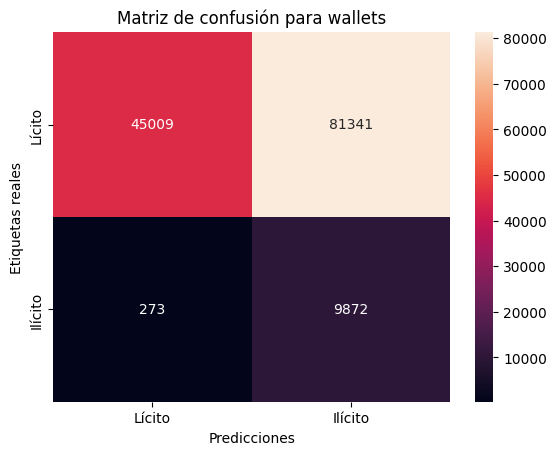

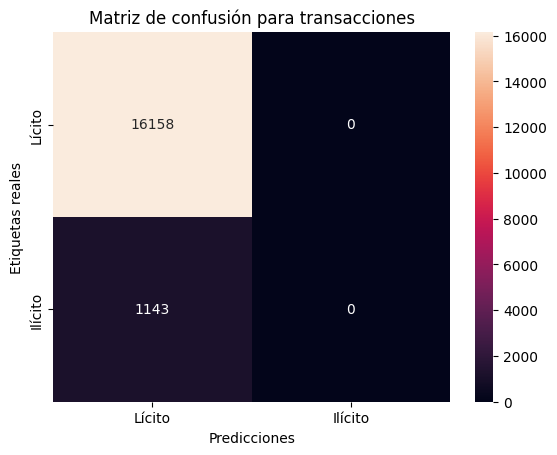

In [ ]:
evaluation_report()

### 5.3. Optimizando wallets y transacciones

--------------------------------------------------------------------
Using 5 training batches
Using 2 testing batches
--------------------------------------------------------------------
Batch 0 wallet imbalance: 68.84, transactions imbalance: 40.31
Batch 1 wallet imbalance: 11.12, transactions imbalance: 4.18
Batch 2 wallet imbalance: 8.24, transactions imbalance: 7.00
Batch 3 wallet imbalance: 4.08, transactions imbalance: 3.46
Batch 4 wallet imbalance: 8.41, transactions imbalance: 13.12
--------------------------------------------------------------------


  0%|          | 0/400 [00:00<?, ?it/s]

-------------------------- Epoch: 010/400 --------------------------
Wallets loss: 1.20639932,	Transactions loss: 1.23001087
Train set wallets ACC: 0.5834,	Train set transactions ACC: 0.1394
Test set wallets ACC: 0.4941,	Test set transactions ACC: 0.1111
--------------------------------------------------------------------
-------------------------- Epoch: 020/400 --------------------------
Wallets loss: 1.00761247,	Transactions loss: 1.21925330
Train set wallets ACC: 0.4672,	Train set transactions ACC: 0.5346
Test set wallets ACC: 0.3013,	Test set transactions ACC: 0.4141
--------------------------------------------------------------------
-------------------------- Epoch: 030/400 --------------------------
Wallets loss: 0.97829610,	Transactions loss: 1.13241446
Train set wallets ACC: 0.5347,	Train set transactions ACC: 0.7171
Test set wallets ACC: 0.3983,	Test set transactions ACC: 0.5904
--------------------------------------------------------------------
-------------------------- E

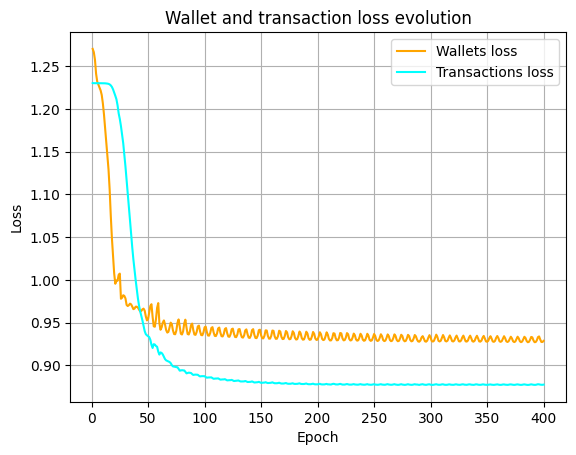

In [ ]:
model = HGT_BinaryClassifier(embedding_dim=64, metadata=metadata, num_heads=8, num_layers=2).to(device)
train_and_eval(balance=0.35, timestep=37, batch_size=8, num_epochs=400, lr=0.01, wd=0.001, th=0.5, verbose=True)

Wallets classification report:
              precision    recall  f1-score   support

       Licit       0.99      0.35      0.51    126350
     Illicit       0.11      0.96      0.19     10145

    accuracy                           0.39    136495
   macro avg       0.55      0.65      0.35    136495
weighted avg       0.92      0.39      0.49    136495

Wallets accuracy score: 0.3918678339865929

Transactions classification report:
              precision    recall  f1-score   support

       Licit       0.99      0.61      0.76     16158
     Illicit       0.15      0.94      0.25      1143

    accuracy                           0.63     17301
   macro avg       0.57      0.77      0.50     17301
weighted avg       0.94      0.63      0.72     17301

Transactions accuracy score: 0.6311195884630946



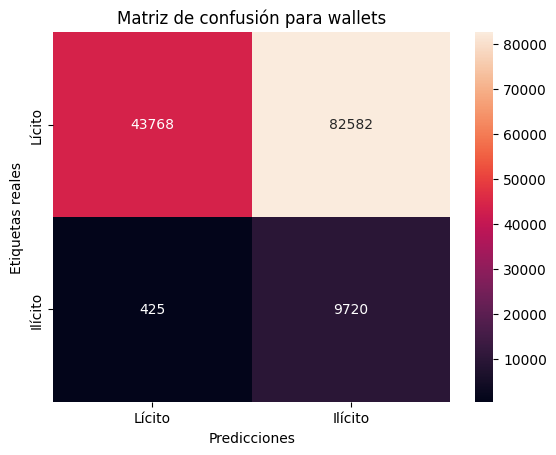

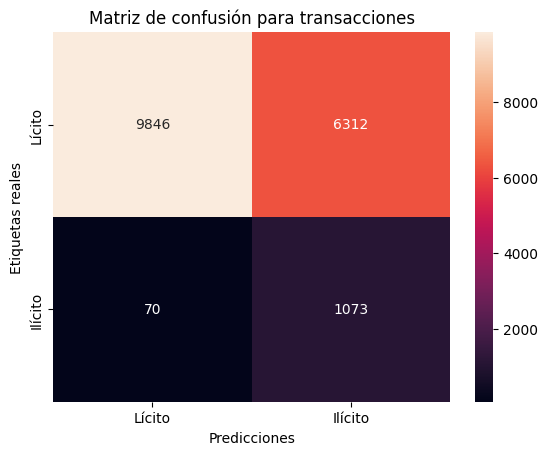

In [ ]:
evaluation_report()

## **6. Conclusiones**

En los tres experimentos realizados, se puede observar claramente en las matrices de confusión que la cantidad de **falsos positivos** es demasiado elevada. Una de las principales razones a las que puede deberse esto, es porque el desbalance entre nodos (tanto transacciones como wallets) ilícitos y lícitos varía considerablemente de un *timestep* a otro.

Esto puede provocar que en los *timesteps* de los lotes con los que se ha entrenado el modelo el desbalance sea mucho mayor que en los *timesteps* usados para la evaluación, provocando que el modelo haga más predicciones de clases positivas que las que deberia, generando así ese elevado número de falsos positivos.

La solución es dividir el conjunto de datos de entrenamiento y *test* de una manera más tradicional, como se hará en la siguiente sección.

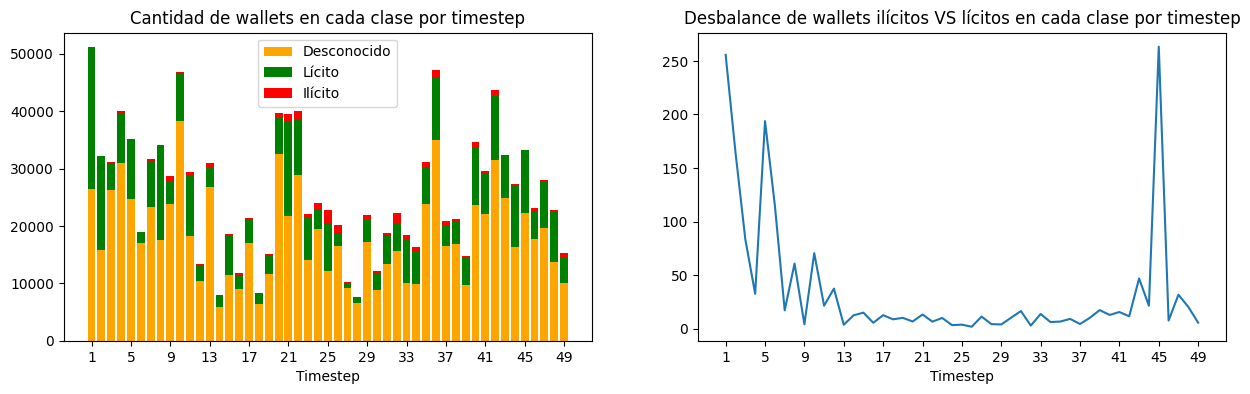

In [ ]:
import matplotlib.pyplot as plt

c_wallet_licit = df_wallet[df_wallet['class'] == 0].groupby('Time step').size()
c_wallet_ilicit = df_wallet[df_wallet['class'] == 1].groupby('Time step').size()
c_wallet_unknown = df_wallet[df_wallet['class'] == 2].groupby('Time step').size()
wallet_imbalance = c_wallet_licit / c_wallet_ilicit

_, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4),sharex=True)
ax1.bar(c_wallet_unknown.index, c_wallet_unknown.values, color = 'orange', label='Desconocido')
ax1.bar(c_wallet_licit.index, c_wallet_licit.values, color='g', bottom=c_wallet_unknown.values, label='Lícito')
ax1.bar(c_wallet_ilicit.index, c_wallet_ilicit.values, color='r', bottom=c_wallet_unknown.values+c_wallet_licit.values, label='Ilícito')
ax1.legend()
ax1.set_xticks(range(1,50,4))
ax1.set_xlabel('Timestep')
ax1.set_title('Cantidad de wallets en cada clase por timestep')

ax2.plot(wallet_imbalance.index, wallet_imbalance.values)
ax2.set_xlabel('Timestep')
ax2.set_title('Desbalance de wallets ilícitos VS lícitos en cada clase por timestep')

plt.show()

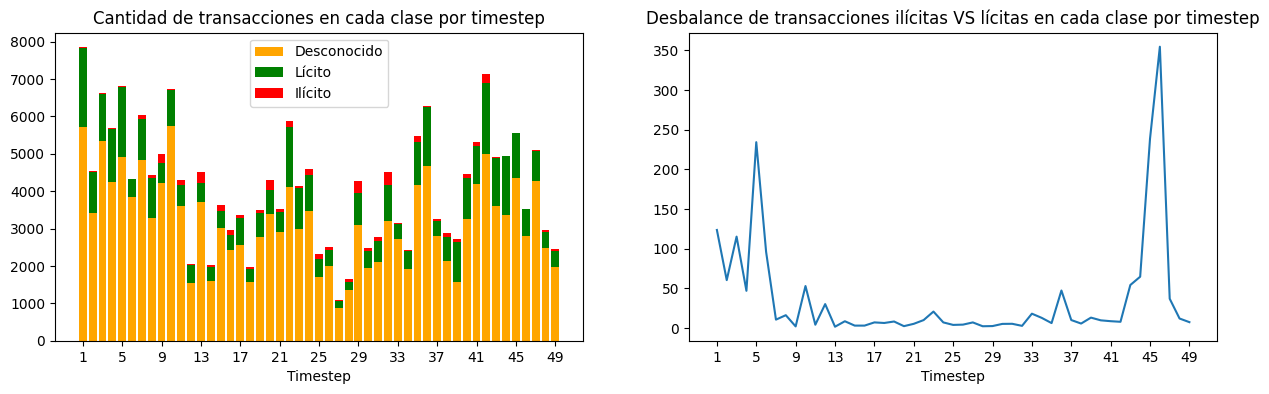

In [ ]:
import matplotlib.pyplot as plt

c_tnx_licit = df_tnx[df_tnx['class'] == 0].groupby('Time step').size()
c_tnx_ilicit = df_tnx[df_tnx['class'] == 1].groupby('Time step').size()
c_tnx_unknown = df_tnx[df_tnx['class'] == 2].groupby('Time step').size()
tnx_imbalance = c_tnx_licit / c_tnx_ilicit

_, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4),sharex=True)
ax1.bar(c_tnx_unknown.index, c_tnx_unknown.values, color = 'orange', label='Desconocido')
ax1.bar(c_tnx_licit.index, c_tnx_licit.values, color='g', bottom=c_tnx_unknown.values, label='Lícito')
ax1.bar(c_tnx_ilicit.index, c_tnx_ilicit.values, color='r', bottom=c_tnx_unknown.values+c_tnx_licit.values, label='Ilícito')
ax1.legend()
ax1.set_xticks(range(1,50,4))
ax1.set_xlabel('Timestep')
ax1.set_title('Cantidad de transacciones en cada clase por timestep')

ax2.plot(tnx_imbalance.index, tnx_imbalance.values)
ax2.set_xlabel('Timestep')
ax2.set_title('Desbalance de transacciones ilícitas VS lícitas en cada clase por timestep')

plt.show()

---
# Segunda aproximación
---

## **2.3. Creación del dataset de PyG**


In [ ]:
rs = 33
test_size = 0.20

In [ ]:
wallet_imbalance = int(len(df_wallet[df_wallet['class']==0])/len(df_wallet[df_wallet['class']==1]))
tnx_imbalance = int(len(df_tnx[df_tnx['class']==0])/len(df_tnx[df_tnx['class']==1]))

print(f'Wallet imbalance: {wallet_imbalance}')
print(f'Transactions imbalance: {tnx_imbalance}')

Wallet imbalance: 11
Transactions imbalance: 9


In [ ]:
def get_masked_edges(masked_df_wallet, masked_df_tx):
    addr_mapping = {addr: idx for idx, addr in enumerate(masked_df_wallet['address'].values)}
    tnx_mapping = {tnx: idx for idx, tnx in enumerate(masked_df_tx['txId'].values)}

    AddrTx_mask = df_AddrTx_edgelist['input_address'].isin(masked_df_wallet['address'].values) & df_AddrTx_edgelist['txId'].isin(masked_df_tx['txId'].values)
    masked_df_AddrTx_edgelist = df_AddrTx_edgelist[AddrTx_mask]
    masked_df_AddrTx_byIdx = pd.DataFrame()
    masked_df_AddrTx_byIdx['source'] = masked_df_AddrTx_edgelist['input_address'].map(addr_mapping)
    masked_df_AddrTx_byIdx['dest'] = masked_df_AddrTx_edgelist['txId'].map(tnx_mapping)

    TxAddr_mask = df_TxAddr_edgelist['txId'].isin(masked_df_tx['txId'].values) & df_TxAddr_edgelist['output_address'].isin(masked_df_wallet['address'].values)
    masked_df_TxAddr_edgelist = df_TxAddr_edgelist[TxAddr_mask]
    masked_df_TxAddr_byIdx = pd.DataFrame()
    masked_df_TxAddr_byIdx['source'] = masked_df_TxAddr_edgelist['txId'].map(tnx_mapping)
    masked_df_TxAddr_byIdx['dest'] = masked_df_TxAddr_edgelist['output_address'].map(addr_mapping)

    return masked_df_AddrTx_byIdx, masked_df_TxAddr_byIdx

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm

dataset = dict()

for t in tqdm(range(1, 50)):
    dataset[t] = HeteroData()

    masked_df_wallet = df_wallet[df_wallet['Time step'] == t].reset_index(drop=True)
    masked_df_tnx = df_tnx[df_tnx['Time step'] == t].reset_index(drop=True)

    # Wallets
    dataset[t]['wallet'].x = torch.tensor(masked_df_wallet[wallet_feature_columns].values).float()
    dataset[t]['wallet'].y = torch.tensor(masked_df_wallet.iloc[:,1].values).float()
    known_wallet = masked_df_wallet[masked_df_wallet['class']!=2]
    train_wallet_indices, test_wallet_indices = train_test_split(known_wallet.index, test_size=test_size, stratify=known_wallet['class'], random_state=rs)
    train_wallet_mask = np.zeros(len(masked_df_wallet), dtype=bool)
    train_wallet_mask[train_wallet_indices] = True
    dataset[t]['wallet'].train_mask = torch.tensor(train_wallet_mask)
    test_wallet_mask = np.zeros(len(masked_df_wallet), dtype=bool)
    test_wallet_mask[test_wallet_indices] = True
    dataset[t]['wallet'].test_mask = torch.tensor(test_wallet_mask)

    # Transacciones
    dataset[t]['tnx'].x = torch.tensor(masked_df_tnx[tnx_feature_columns].values).float()
    dataset[t]['tnx'].y = torch.tensor(masked_df_tnx.iloc[:,1].values).float()
    known_tnx = masked_df_tnx[masked_df_tnx['class']!=2]
    train_tnx_indices, test_tnx_indices = train_test_split(known_tnx.index, test_size=test_size, stratify=known_tnx['class'], random_state=rs)
    train_tnx_mask = np.zeros(len(masked_df_tnx), dtype=bool)
    train_tnx_mask[train_tnx_indices] = True
    dataset[t]['tnx'].train_mask = torch.tensor(train_tnx_mask)
    test_tnx_mask = np.zeros(len(masked_df_tnx), dtype=bool)
    test_tnx_mask[test_tnx_indices] = True
    dataset[t]['tnx'].test_mask = torch.tensor(test_tnx_mask)

    # Conexiones Wallet -> Transaccion y Transaccion -> Wallet
    masked_df_AddrTx_byIdx, masked_df_TxAddr_byIdx = get_masked_edges(masked_df_wallet, masked_df_tnx)
    dataset[t]['wallet', 'sends', 'tnx'].edge_index = torch.from_numpy(masked_df_AddrTx_byIdx.values).t().contiguous()
    dataset[t]['tnx', 'delivers', 'wallet'].edge_index = torch.from_numpy(masked_df_TxAddr_byIdx.values).t().contiguous()

    try:
        dataset[t].validate()
    except ValueError as err:
        print(f'Fallo en el timestep {t}')
        print(err)
        raise

metadata = dataset[1].metadata()    # Es el mismo para todos los time steps


  0%|          | 0/49 [00:00<?, ?it/s]

## **3. Entrenamiento del modelo**

Entrenamiento con ```DataLoader``` y  *mini batching*

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from torch.nn import BCEWithLogitsLoss
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_curve,roc_auc_score,RocCurveDisplay
from HGT_Binary_Classifier import HGT_BinaryClassifier



In [ ]:

def train(train_loader, balance=0.5, wallet_imbalances=None, tnx_imbalances=None):
    global model
    global optimizer

    if wallet_imbalances is None or len(wallet_imbalances) != len(train_loader):
        print('Wallet imbalances no válido')
        wallet_imbalances = [1]*len(train_loader)
    if tnx_imbalances is None or len(tnx_imbalances) != len(train_loader):
        print('Transaction imbalances no válido')
        tnx_imbalances = [1]*len(train_loader)

    model.train()

    total_wallet_loss = total_tnx_loss = 0
    total_wallet_samples = total_tnx_samples = 0

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        batch = batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)

        wallet_mask = batch['wallet'].train_mask
        wallet_num = wallet_mask.sum()
        tnx_mask = batch['tnx'].train_mask
        tnx_num = tnx_mask.sum()

        wallet_loss_func = BCEWithLogitsLoss(pos_weight=wallet_imbalances[i])
        tnx_loss_func = BCEWithLogitsLoss(pos_weight=tnx_imbalances[i])

        wallet_loss = wallet_loss_func(out['wallet'][wallet_mask], batch['wallet'].y[wallet_mask])
        tnx_loss = tnx_loss_func(out['tnx'][tnx_mask], batch['tnx'].y[tnx_mask])

        loss = wallet_loss*balance + tnx_loss*(1-balance)
        loss.backward()
        optimizer.step()

        total_wallet_loss += float(wallet_loss) * wallet_num
        total_wallet_samples += wallet_num
        total_tnx_loss += float(tnx_loss) * tnx_num
        total_tnx_samples += tnx_num

    return (total_wallet_loss/total_wallet_samples), (total_tnx_loss/total_tnx_samples)


@torch.no_grad()
def test(test_loader, use_train_mask=False, threshold=0.5):
    global model

    model.eval()

    wallet_total_pred = wallet_correct_pred = 0
    tnx_total_pred = tnx_correct_pred = 0

    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch.x_dict, batch.edge_index_dict)

        if use_train_mask:
            wallet_test_mask = batch['wallet'].train_mask
        else:
            wallet_test_mask = batch['wallet'].test_mask

        wallet_bin_pred = (torch.sigmoid(pred['wallet']) > threshold).float()
        wallet_correct_pred += (wallet_bin_pred[wallet_test_mask] == batch['wallet'].y[wallet_test_mask]).sum()
        wallet_total_pred += wallet_test_mask.sum()

        if use_train_mask:
            tnx_test_mask = batch['tnx'].train_mask
        else:
            tnx_test_mask = batch['tnx'].test_mask

        tnx_bin_pred = (torch.sigmoid(pred['tnx']) > threshold).float()
        tnx_correct_pred += (tnx_bin_pred[tnx_test_mask] == batch['tnx'].y[tnx_test_mask]).sum()
        tnx_total_pred += tnx_test_mask.sum()

    wallet_acc = wallet_correct_pred / wallet_total_pred
    tnx_acc = tnx_correct_pred / tnx_total_pred
    return wallet_acc, tnx_acc


In [ ]:
def get_filename(params: dict) -> str:
    file_name = './Plots/HGT/hgt'
    file_name += f'_ed{params["embedding_dim"]}'
    file_name += f'_nh{params["num_heads"]}'
    file_name += f'_nl{params["num_layers"]}'
    file_name += f'_b{params["balance"]}'
    file_name += f'_bs{params["batch_size"]}'
    file_name += f'_ne{params["num_epochs"]}'
    file_name += f'_lr{params["lr"]}'
    file_name += f'_wd{params["wd"]}'
    file_name += f'_wi{params["wallet_imbalances"]}'
    file_name += f'_ti{params["tnx_imbalances"]}'
    return file_name

In [ ]:

def train_and_eval(balance, batch_size, num_epochs, lr, wd, class_imbalance='per_batch', th=0.5, verbose=False, filename=None):
    global model
    global optimizer

    data_loader = DataLoader([dataset[t] for t in range(1,50)], batch_size=batch_size)

    if class_imbalance=='per_batch':
        wallet_imbalances = []
        tnx_imbalances = []
        for i, batch in enumerate(data_loader):
            wallet_mask = batch['wallet'].train_mask
            wallet_true_labels = batch['wallet'].y[wallet_mask]
            wallet_imbalances.append((wallet_true_labels==0).sum() / wallet_true_labels.sum())
            tnx_mask = batch['tnx'].train_mask
            tnx_true_labels = batch['tnx'].y[tnx_mask]
            tnx_imbalances.append((tnx_true_labels==0).sum() / tnx_true_labels.sum())
            if verbose:
                print(f'Batch {i} wallet imbalance: {wallet_imbalances[i]:.2f}, transactions imbalance: {tnx_imbalances[i]:.2f}')
        if verbose:
            print(f'--------------------------------------------------------------------')
    elif (isinstance(class_imbalance, tuple)) and (len(class_imbalance)==2) and (all(isinstance(x, (int,float)) for x in class_imbalance)):
        wallet_imbalances = [torch.tensor(class_imbalance[0])]*len(data_loader)
        tnx_imbalances = [torch.tensor(class_imbalance[1])]*len(data_loader)
    else:
        print('Invalid class_imbalance argument')
        raise

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    epochs = range(1,num_epochs+1)
    wallet_loss_list = []
    tnx_loss_list = []

    for epoch in tqdm(epochs):
        wallet_loss, tnx_loss = train(data_loader, balance, wallet_imbalances, tnx_imbalances)
        train_wallet_acc, train_tnx_acc = test(data_loader, use_train_mask=True, threshold=th)
        test_wallet_acc, test_tnx_acc = test(data_loader, threshold=th)
        if verbose and (epoch-1)%10 == 0:
            print(f'-------------------------- Epoch: {epoch:03d}/{num_epochs:03d} --------------------------')
            print(f'Wallets loss: {wallet_loss:.8f},\tTransactions loss: {tnx_loss:.8f}')
            print(f'Train set wallets ACC: {train_wallet_acc:.4f},\tTrain set transactions ACC: {train_tnx_acc:.4f}')
            print(f'Test set wallets ACC: {test_wallet_acc:.4f},\tTest set transactions ACC: {test_tnx_acc:.4f}')
            print(f'--------------------------------------------------------------------')
        wallet_loss_list.append(wallet_loss.cpu())
        tnx_loss_list.append(tnx_loss.cpu())

    plt.figure(figsize=(8,8))
    plt.plot(epochs, wallet_loss_list, label='Pérdida de los wallets', color='orange')
    plt.plot(epochs, tnx_loss_list, label='Pérdida de las transacciones', color='cyan')
    plt.xlabel('Epoch')
    plt.ylabel('Función de pérdida')
    plt.legend()
    if filename is not None:
        plt.savefig(f'{filename}_loss.eps',format='eps',bbox_inches='tight')
    plt.show()
    plt.close()


In [ ]:

def evaluation_report(filename=None):
    test_loader = DataLoader([dataset[t] for t in range(1,50)], batch_size=8)

    all_wallet_probs = []
    all_wallet_labels = []
    all_tnx_probs = []
    all_tnx_labels = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch.x_dict, batch.edge_index_dict)

            wallet_test_mask = batch['wallet'].test_mask
            all_wallet_probs.extend(torch.sigmoid(pred['wallet'][wallet_test_mask]).cpu().numpy())
            all_wallet_labels.extend(batch['wallet'].y[wallet_test_mask].cpu().numpy())

            tnx_test_mask = batch['tnx'].test_mask
            all_tnx_probs.extend(torch.sigmoid(pred['tnx'][tnx_test_mask]).cpu().numpy())
            all_tnx_labels.extend(batch['tnx'].y[tnx_test_mask].cpu().numpy())

    all_wallet_probs = np.array(all_wallet_probs)
    all_wallet_labels = np.array(all_wallet_labels)
    all_tnx_probs = np.array(all_tnx_probs)
    all_tnx_labels = np.array(all_tnx_labels)

    all_wallet_preds = np.round(all_wallet_probs)
    all_tnx_preds = np.round(all_tnx_probs)

    wallet_auc = roc_auc_score(all_wallet_labels, all_wallet_probs)
    tnx_auc = roc_auc_score(all_tnx_labels, all_tnx_probs)

    if (len(np.unique(all_wallet_preds)) > 1):
        print('Wallets classification report:')
        print(classification_report(all_wallet_labels, all_wallet_preds, target_names=['Licit', 'Illicit']))
        print(f'Wallets ROC AUC score: {wallet_auc}')
        print('')
    if (len(np.unique(all_tnx_preds)) > 1):
        print('Transactions classification report:')
        print(classification_report(all_tnx_labels, all_tnx_preds, target_names=['Licit', 'Illicit']))
        print(f'Transactions ROC AUC score: {tnx_auc}')
        print('')

    if filename is not None:
        with open(f'{filename}_report.txt', 'w') as f_report:
            if (len(np.unique(all_wallet_preds)) > 1):
                f_report.write('Wallets classification report:')
                f_report.write(classification_report(all_wallet_labels, all_wallet_preds, target_names=['Licit', 'Illicit']))
                f_report.write(f'Wallets accuracy score: {wallet_auc}')
                f_report.write('')
            if (len(np.unique(all_tnx_preds)) > 1):
                f_report.write('Transactions classification report:')
                f_report.write(classification_report(all_tnx_labels, all_tnx_preds, target_names=['Licit', 'Illicit']))
                f_report.write(f'Transactions accuracy score: {tnx_auc}')
                f_report.write('')


    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(all_wallet_labels, all_wallet_preds), annot=True, fmt='d',
                xticklabels=['Lícito', 'Ilícito'],
                yticklabels=['Lícito', 'Ilícito'])
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas reales')
    print('Matriz de confusión para wallets')
    if filename is not None:
        plt.savefig(f'{filename}_cm_wallets.eps',format='eps',bbox_inches='tight')
    plt.show()
    plt.close()

    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(all_tnx_labels, all_tnx_preds), annot=True, fmt='d',
                xticklabels=['Lícito', 'Ilícito'],
                yticklabels=['Lícito', 'Ilícito'])
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas reales')
    print('Matriz de confusión para transacciones')
    if filename is not None:
        plt.savefig(f'{filename}_cm_tnx.eps',format='eps',bbox_inches='tight')
    plt.show()
    plt.close()


    wallet_fpr, wallet_tpr, _ = roc_curve(all_wallet_labels, all_wallet_probs)
    plt.figure(figsize=(4,4))
    wallet_roc_disp = RocCurveDisplay(fpr=wallet_fpr, tpr=wallet_tpr, roc_auc=wallet_auc)
    wallet_roc_disp.plot(color='orange')
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    print('Curva ROC para wallets')
    if filename is not None:
        plt.savefig(f'{filename}_roc_wallet.eps',format='eps',bbox_inches='tight')
    plt.show()
    plt.close()

    tnx_fpr, tnx_tpr, _ = roc_curve(all_tnx_labels, all_tnx_probs)
    fig = plt.figure(figsize=(4,4))
    tnx_roc_disp = RocCurveDisplay(fpr=tnx_fpr, tpr=tnx_tpr, roc_auc=tnx_auc)
    tnx_roc_disp.plot(color='cyan')
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    print('Curva ROC para transacciones')
    if filename is not None:
        plt.savefig(f'{filename}_roc_tnx.eps',format='eps',bbox_inches='tight')
    plt.show()
    plt.close()


## **4. Experimentos**

In [ ]:

sns.set_style('darkgrid')
sns.set_context('paper')
!mkdir -p ./Plots/HGT/
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 5.1. Optimizando solo transacciones

  0%|          | 0/200 [00:00<?, ?it/s]

-------------------------- Epoch: 001/200 --------------------------
Wallets loss: 0.93103766,	Transactions loss: 0.98394561
Train set wallets ACC: 0.0778,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.0778,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 011/200 --------------------------
Wallets loss: 0.90131480,	Transactions loss: 0.90651381
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 021/200 --------------------------
Wallets loss: 0.91150755,	Transactions loss: 0.90716487
Train set wallets ACC: 0.0778,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.0778,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- E

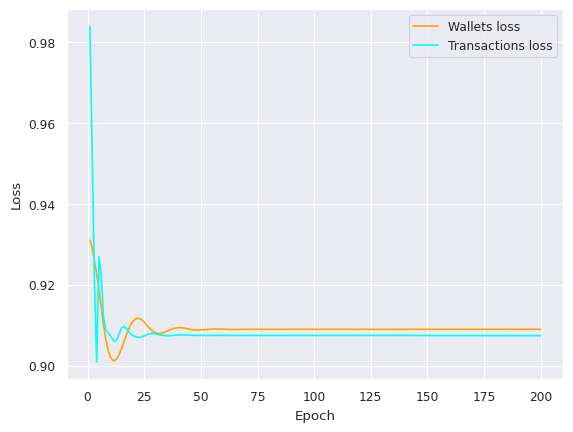

In [ ]:
model = HGT_BinaryClassifier(embedding_dim=64, metadata=metadata, num_heads=4, num_layers=2).to(device)
train_and_eval(balance=0, batch_size=32, num_epochs=200, class_imbalance=(5,5), lr=0.01, wd=0.001, th=0.5, verbose=True)

Matriz de confusión para wallets


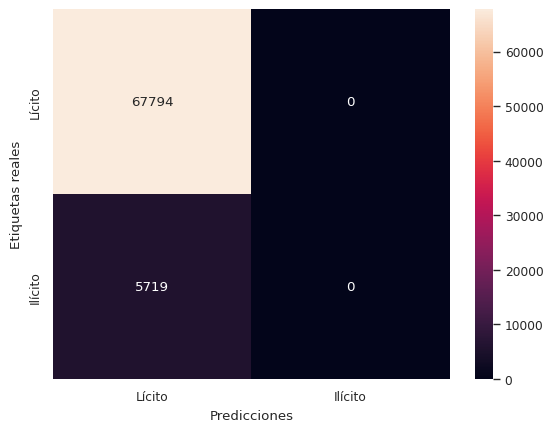

Matriz de confusión para transacciones


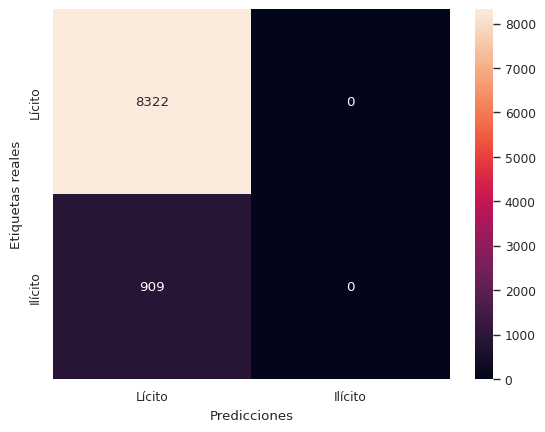

In [ ]:
evaluation_report()

### 5.2. Optimizando solo wallets

In [ ]:
model = HGT_BinaryClassifier(embedding_dim=64, metadata=metadata, num_heads=4, num_layers=2).to(device)
train_and_eval(balance=1, batch_size=32, num_epochs=200, class_imbalance=(5,5), lr=0.005, wd=0.001, th=0.5, verbose=True)

  0%|          | 0/200 [00:00<?, ?it/s]

-------------------------- Epoch: 001/200 --------------------------
Wallets loss: 0.88959527,	Transactions loss: 0.96316874
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 011/200 --------------------------
Wallets loss: 0.78084373,	Transactions loss: 0.96709931
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.0988
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.0985
--------------------------------------------------------------------
-------------------------- Epoch: 021/200 --------------------------
Wallets loss: 0.78088772,	Transactions loss: 0.96709061
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.0988
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.0985
--------------------------------------------------------------------
-------------------------- E

KeyboardInterrupt: 

In [ ]:
evaluation_report()

### 5.3. Optimizando wallets y transacciones

  0%|          | 0/400 [00:00<?, ?it/s]

-------------------------- Epoch: 001/400 --------------------------
Wallets loss: 0.92397887,	Transactions loss: 0.91369081
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 011/400 --------------------------
Wallets loss: 0.83609557,	Transactions loss: 0.85641789
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 021/400 --------------------------
Wallets loss: 0.83308291,	Transactions loss: 0.85569346
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- E

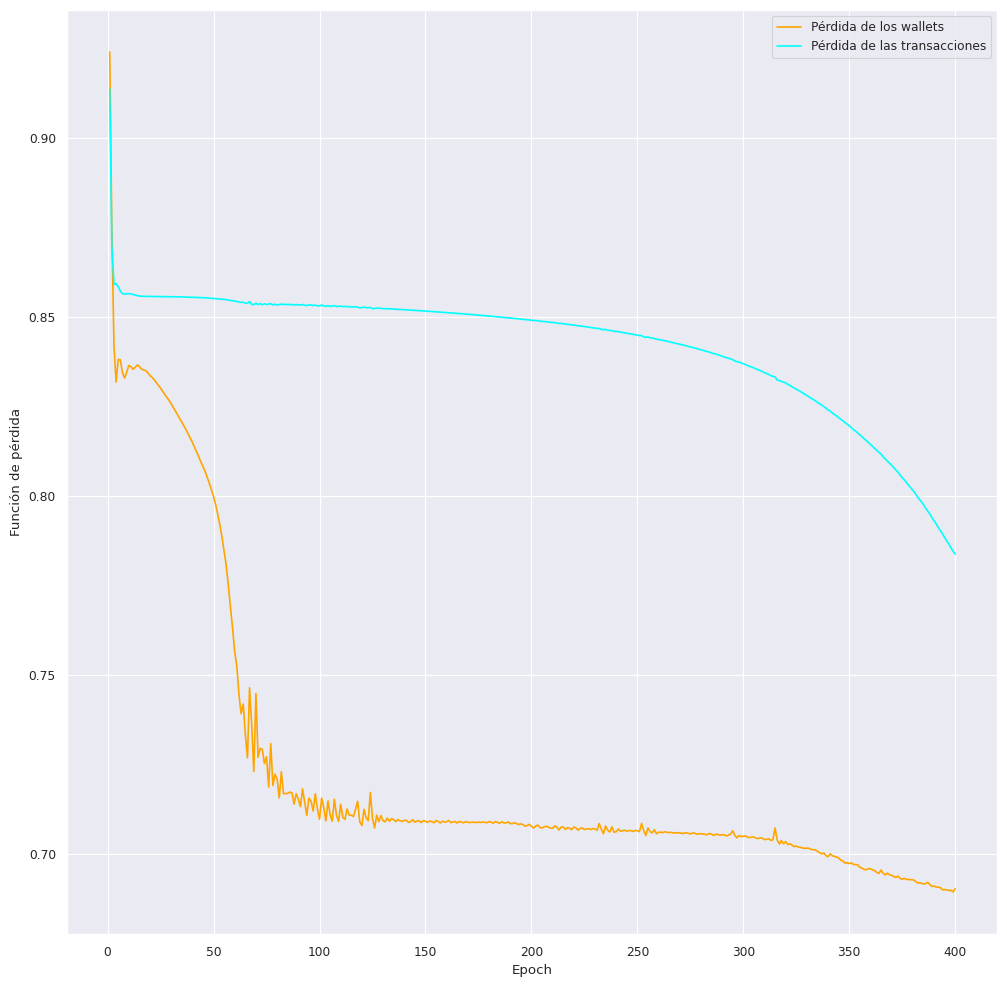

In [ ]:
params = {
    'embedding_dim': 128,
    'num_heads': 4,
    'num_layers': 2,
    'balance': 0.35,
    'batch_size': 16,
    'wallet_imbalances': 5.5,
    'tnx_imbalances': 5,
    'num_epochs': 400,
    'lr': 0.01,
    'wd': 0.001
}
filename = get_filename(params)
model = HGT_BinaryClassifier(embedding_dim=params['embedding_dim'], num_heads=params['num_heads'], num_layers=params['num_layers'], metadata=metadata).to(device)
train_and_eval(balance=params['balance'], batch_size=params['batch_size'],
               class_imbalance=(params['wallet_imbalances'],params['tnx_imbalances']),
               num_epochs=params['num_epochs'], lr=params['lr'], wd=params['wd'],
               th=0.5, verbose=True, filename=filename)

Wallets classification report:
              precision    recall  f1-score   support

       Licit       0.94      0.93      0.94     67794
     Illicit       0.27      0.29      0.28      5719

    accuracy                           0.88     73513
   macro avg       0.60      0.61      0.61     73513
weighted avg       0.89      0.88      0.89     73513

Wallets ROC AUC score: 0.7733194240043287

Matriz de confusión para wallets


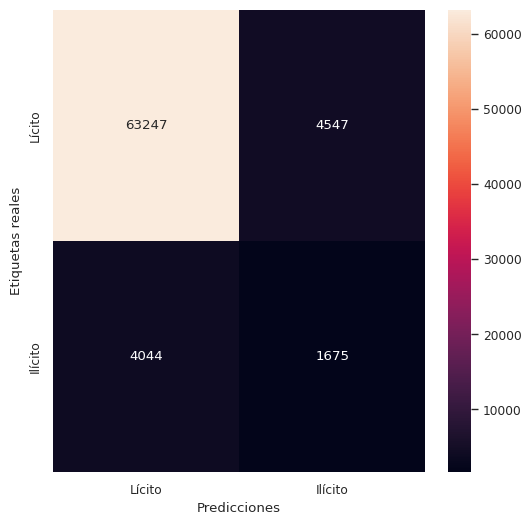

Matriz de confusión para transacciones


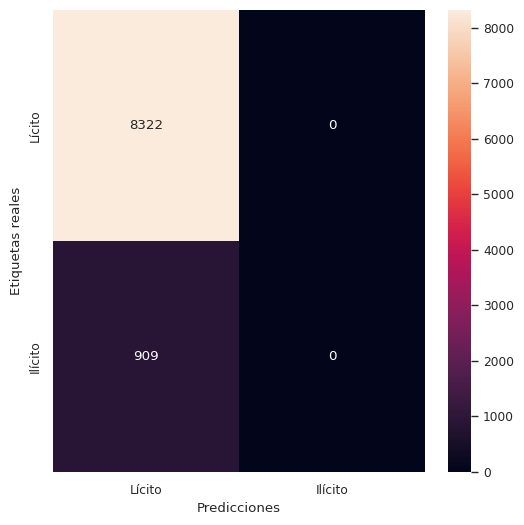

Curva ROC para wallets


<Figure size 600x600 with 0 Axes>

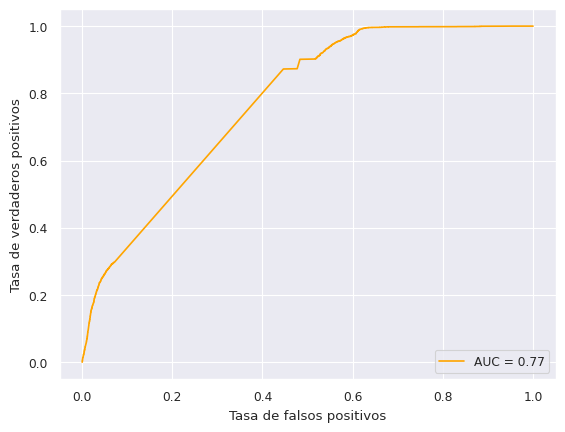

Curva ROC para transacciones


<Figure size 600x600 with 0 Axes>

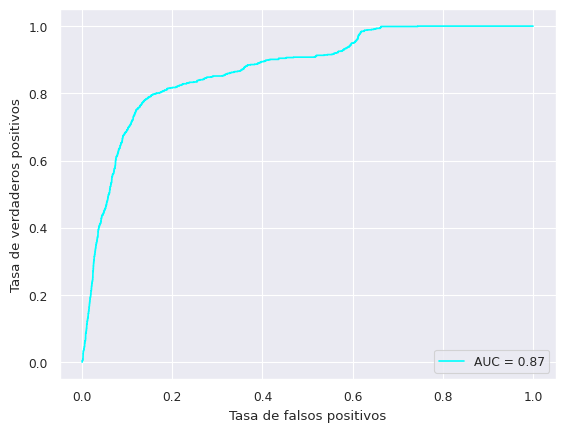

In [ ]:
evaluation_report(filename=filename)

### 5.3. Optimizando wallets y transacciones

  0%|          | 0/400 [00:00<?, ?it/s]

-------------------------- Epoch: 001/400 --------------------------
Wallets loss: 0.88554853,	Transactions loss: 0.94859099
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 011/400 --------------------------
Wallets loss: 0.79749542,	Transactions loss: 0.91483170
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 021/400 --------------------------
Wallets loss: 0.78703672,	Transactions loss: 0.91458541
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- E

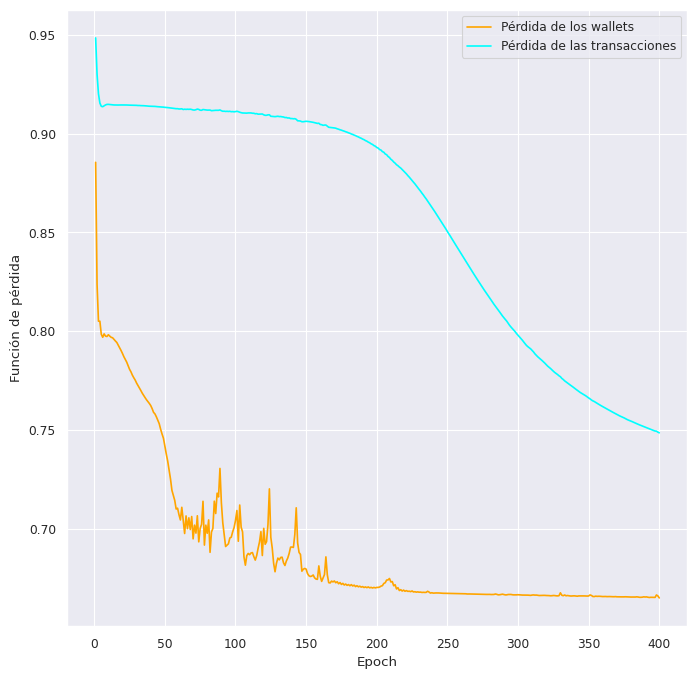

In [ ]:
params = {
    'embedding_dim': 128,
    'num_heads': 4,
    'num_layers': 2,
    'balance': 0.3,
    'batch_size': 8,
    'wallet_imbalances': 5,
    'tnx_imbalances': 5,
    'num_epochs': 400,
    'lr': 0.01,
    'wd': 0.001
}
filename = get_filename(params)
model = HGT_BinaryClassifier(embedding_dim=params['embedding_dim'], num_heads=params['num_heads'], num_layers=params['num_layers'], metadata=metadata).to(device)
train_and_eval(balance=params['balance'], batch_size=params['batch_size'],
               class_imbalance=(params['wallet_imbalances'],params['tnx_imbalances']),
               num_epochs=params['num_epochs'], lr=params['lr'], wd=params['wd'],
               th=0.5, verbose=True, filename=filename)


Wallets classification report:
              precision    recall  f1-score   support

       Licit       0.94      0.93      0.93     67794
     Illicit       0.23      0.25      0.24      5719

    accuracy                           0.88     73513
   macro avg       0.59      0.59      0.59     73513
weighted avg       0.88      0.88      0.88     73513

Wallets ROC AUC score: 0.8127863854739523

Transactions classification report:
              precision    recall  f1-score   support

       Licit       0.97      0.94      0.95      8322
     Illicit       0.55      0.72      0.63       909

    accuracy                           0.91      9231
   macro avg       0.76      0.83      0.79      9231
weighted avg       0.93      0.91      0.92      9231

Transactions ROC AUC score: 0.8942631285478944

Matriz de confusión para wallets


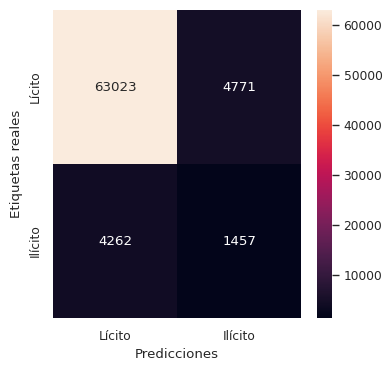

Matriz de confusión para transacciones


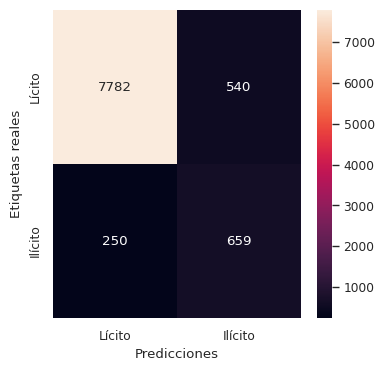

Curva ROC para wallets


<Figure size 400x400 with 0 Axes>

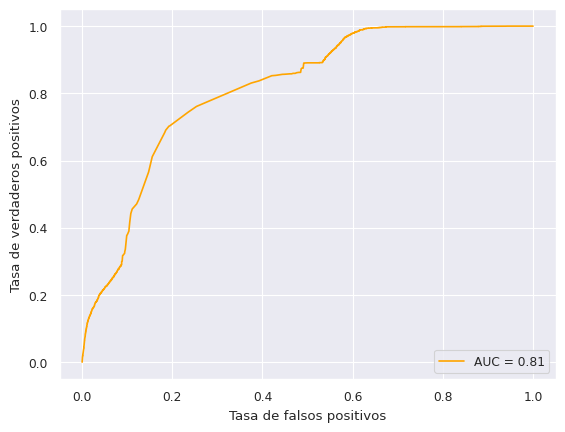

Curva ROC para transacciones


<Figure size 400x400 with 0 Axes>

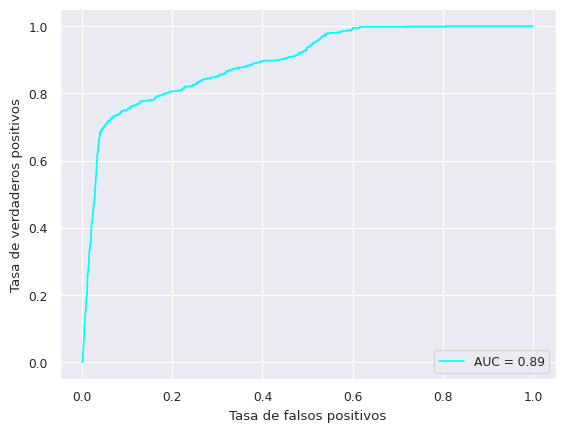

In [ ]:
evaluation_report(filename=filename)

### 5.3. Optimizando wallets y transacciones (buenos resultados)

  0%|          | 0/400 [00:00<?, ?it/s]

-------------------------- Epoch: 001/400 --------------------------
Wallets loss: 0.88132387,	Transactions loss: 0.95736581
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 011/400 --------------------------
Wallets loss: 0.79791689,	Transactions loss: 0.91476440
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- Epoch: 021/400 --------------------------
Wallets loss: 0.79511690,	Transactions loss: 0.91455472
Train set wallets ACC: 0.9222,	Train set transactions ACC: 0.9012
Test set wallets ACC: 0.9222,	Test set transactions ACC: 0.9015
--------------------------------------------------------------------
-------------------------- E

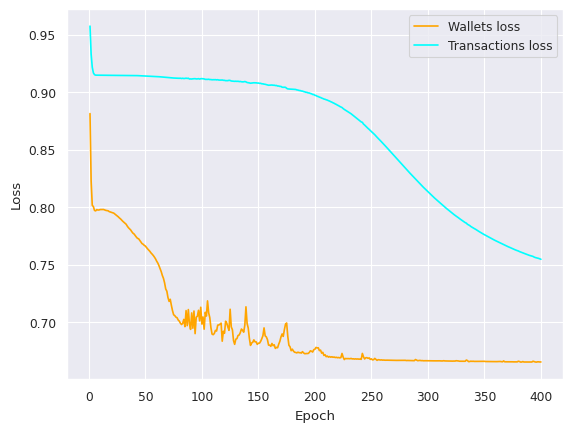

In [ ]:
model = HGT_BinaryClassifier(embedding_dim=128, metadata=metadata, num_heads=4, num_layers=2).to(device)
train_and_eval(balance=0.3, batch_size=8, class_imbalance=(5,5), num_epochs=400, lr=0.01, wd=0.001, th=0.5, verbose=True)

Wallets classification report:
              precision    recall  f1-score   support

       Licit       0.94      0.93      0.93     67794
     Illicit       0.23      0.26      0.25      5719

    accuracy                           0.87     73513
   macro avg       0.58      0.59      0.59     73513
weighted avg       0.88      0.87      0.88     73513

Wallets accuracy score: 0.8748928760899433

Transactions classification report:
              precision    recall  f1-score   support

       Licit       0.97      0.95      0.96      8322
     Illicit       0.60      0.70      0.65       909

    accuracy                           0.92      9231
   macro avg       0.78      0.83      0.80      9231
weighted avg       0.93      0.92      0.93      9231

Transactions accuracy score: 0.9247102155779439

Matriz de confusión para wallets


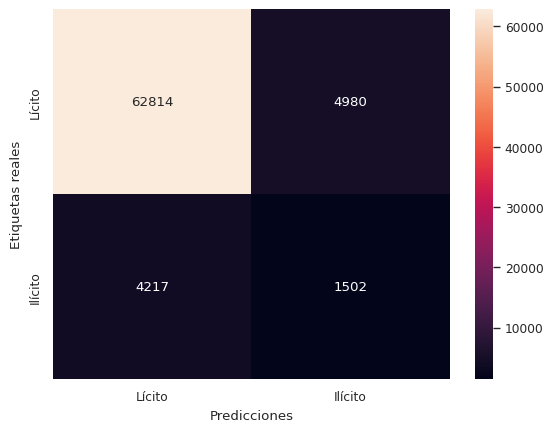

Matriz de confusión para transacciones


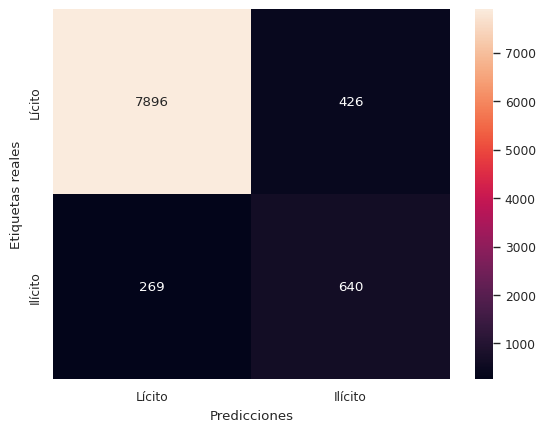

In [ ]:
evaluation_report()

---
---
---
# Pruebas...

In [ ]:
data['wallet'].y.dtype

torch.int64

In [ ]:
predicciones = torch.randn(245667, 1)  # Tensor de predicciones
objetivos = torch.randn(245667)        # Tensor de objetivos


In [ ]:
predicciones.t()[0]

tensor([ 1.3941, -0.8494, -0.3877,  ...,  1.0979, -1.5160, -0.3692])

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear

# We initialize conference node features with a single one-vector as feature:
dataset = DBLP('./data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)


Extracting data/raw/DBLP_processed.zip
Processing...
Done!


HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [ ]:
data['author'].x

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
data['author','to','paper'].edge_index

tensor([[    0,     0,     1,  ...,  4054,  4055,  4056],
        [ 2364,  6457,  2365,  ..., 13891, 13891, 13892]])

In [ ]:
out[mask]

tensor([[ 0.0122, -0.1087, -0.0275, -0.0608],
        [ 0.0181, -0.1169, -0.0328, -0.0423],
        [ 0.0383, -0.0697, -0.0017, -0.0279],
        ...,
        [ 0.0141, -0.1124, -0.0295, -0.0508],
        [ 0.0218, -0.0993, -0.0160, -0.0414],
        [ 0.0187, -0.1057, -0.0229, -0.0442]], device='cuda:0')

Parámetros del modelo:
*   Dimension de los *embeddings:* $128$
*   Número de *multi-head-attentions:* $2$
*   Número de capas convolucionales: $2$

Parámetros de entrenamiento:
*   *Learning rate:* $0'005$
*   *Weight decay:* $0'001$
*   *Timesteps* del conjunto de entrenamiento: $[1,32]$
*   *Timesteps* del conjunto de test: $[33,49]$
*   Balance de entrenamiento *wallets/transacciones:* $0.35$ &nbsp; *hay más wallets que transacciones en el dataset
*   Número de *epochs:* $80$
*   Tamaño del *batch:* $8$
